In [1]:
import keras

Using Theano backend.


In [2]:
from keras import backend as K

In [3]:
%matplotlib inline

### Libraries to import

In [4]:
import os
from glob import glob
import matplotlib.pyplot as plt

In [5]:
# For shuffling
import random

In [6]:
#For copying
import shutil

In [7]:
import numpy as np
np.set_printoptions(precision=4, linewidth=100)

#### Stuck on how he creates the paths

In [8]:
path = "data/dogscats/"

Fairly easy - no need to specify current working directory

In [9]:
#Look at what's in the folder
os.listdir(path)

['sample_submission.csv', 'test', 'train', 'sample', 'train.zip', 'test.zip']

### What do I need to do? 

1. Setting up directories - **done**
2. Create a random subset of pictures into the sample folder and split into train and validation - **done**
3. Setup Keras to train this sample using the vgg model  
    * Download the model files
    * Setup the model - including the number of layers at each level
    * Train using batches
4. Check how the model performs
5. If everything works, train on the full set of data and make predictions on the test set
6. Submit to kaggle using kg cli

#### 1. Random subsets in sample directory

In [13]:
dog_files = glob(path + 'train/dog*.jpg')
cat_files =  glob(path + 'train/cat*.jpg')

In [15]:
#Shuffle the list
random.shuffle(dog_files)
random.shuffle(cat_files)

In [19]:
def get_random_samples(files_list, start=None, end=None):
    # Get a random sample of n files
    return files_list[start:end]

In [26]:
def copy_samples_to_dir(files_list, dest_path, number_of_samples=40):
    for file in files_list[:number_of_samples]:
        shutil.copy(file, dest_path)

In [22]:
# Get a small subset of files for testing
cat_sample_train = get_random_samples(cat_files,None,40)

In [27]:
copy_samples_to_dir(cat_sample_train, path + 'sample/train/cat/')

In [28]:
dog_sample_train = get_random_samples(dog_files,None, 40)
copy_samples_to_dir(dog_sample_train,path + 'sample/train/dog/')

In [31]:
# Create another subset for validation
cat_sample_valid = get_random_samples(cat_files,-40, None)
dog_sample_valid = get_random_samples(dog_files, -40, None)

In [30]:
copy_samples_to_dir(cat_sample_valid, path + 'sample/valid/cat/')

In [32]:
copy_samples_to_dir(dog_sample_valid, path + 'sample/valid/dog/')

### 2. Setting up Keras

In [10]:
from importlib import reload

In [11]:
import keras
reload(keras)

<module 'keras' from '/home/vijay/tools/miniconda3/envs/deep-learner/lib/python3.5/site-packages/keras/__init__.py'>

In [12]:
K.set_image_dim_ordering('th')

In [13]:
# For downloading files
from keras.utils.data_utils import get_file
# For json files
import json

In [39]:
?get_file

In [14]:
FILES_PATH = 'http://www.platform.ai/models/'
CLASS_FILE = 'imagenet_class_index.json'

fpath = get_file(CLASS_FILE, FILES_PATH, cache_subdir='models')
with open(fpath) as file:
    class_dict = json.load(file)

In [15]:
# Keep only the name for the clases
classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

In [16]:
classes[:5]

['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead']

### Set up the blocks for the deep learning model

#### First, import the needed stuff from Keras
Keras seems to be built on having abstractions for different kind of layers
and different kind of optimizers and has some preprocessing utilities

In [17]:
# We are going to use a sequential model - this probably differs from the other types of neural networks 
from keras.models import Sequential, Model

In [18]:
#import the different kind of layers
from keras.layers import Dense, Flatten, Dropout, Lambda
from keras.layers import Input
# Import the various convolutional layers stuff
from keras.layers.convolutional import ZeroPadding2D, MaxPooling2D, Convolution2D
#Import the optimizers
from keras.optimizers import SGD, RMSprop
#Preprocessing
from keras.preprocessing import image

## Model 
Consists of two blocks - a fully connected block and a convolution block (but different kinds of convolutional layers)
### Defining a convolutional block
We first add zero to the model - is this adding a bias?  
Then define a convolutional block that takes in the filters and has size 3x3  
and then we add a maxpooling layer - not sure what this does yet

In [19]:
def ConvBlock(layers, model, filters):
    #add a zeropadding for each layers
    for layer in range(layers):
        # each layer in the model add zeropadding
        model.add(ZeroPadding2D((1,1)))
        #Add the convolution layer
        model.add(Convolution2D(filters,(3,3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    

### Defining fully connected block
Adding a fully connected block with a size of 4096 as per the lesson 1 example - where does this size come from?  
and adding a dropout block with 0.5 - what exactly does dropout do? 

In [20]:
def FCBlock(model):
    #Adding a fully connected block - where is 4096 coming from? 
    #NU
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

#### Preprocessing the image by subtracting the mean

In [21]:
# Provided by the vgg team - average of the colours from the total set of images
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))

def vgg_preprocess(x):
    x = x - vgg_mean #Subtract mean
    return x[:,::-1] #Reverse the order bgr -> rgb

#### Create the model

In [119]:
def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess,input_shape = (3, 224, 224)))
    # Add the Convolution blocks
    ConvBlock(2, model, 64)
    ConvBlock(2, model ,128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)
    #Flatten the model? 
    model.add(Flatten())
    
    #Add some Fully connected blocks
    FCBlock(model)
    FCBlock(model)
    
    #Add final layer? 
    model.add(Dense(1000, activation='softmax'))
    return model

#### Instantiate the model

In [23]:
model = VGG_16()

/home/vijay/tools/miniconda3/envs/deep-learner/lib/python3.5/site-packages/keras/layers/core.py:640: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [120]:
fpath = get_file('vgg16.h5', FILES_PATH, cache_subdir='models')

In [121]:
model.load_weights(fpath)

In [26]:
batch_size = 4

In [27]:
# The get_batches function uses the image.ImageDataGenerator.flow_from_directory
# shuffles a bunch of images and returns a batch of them
def get_batches(dirname, gen=image.ImageDataGenerator(), batch_size=batch_size,
                shuffle=True, class_mode='categorical'):
    return gen.flow_from_directory(path + dirname,target_size=(224,224),
                                   shuffle=shuffle,batch_size=batch_size, class_mode=class_mode)

Found 240 images belonging to 2 classes.


In [122]:
# This wasn't working because PIL wasn't available - using pillow instead
images, labels = next(batches)
#Pillow works

In [123]:
def to_plot(img):
    if K.image_dim_ordering == 'tf':
        # if tensorflow is being used - move axis 0 to 1 
        return np.rollaxis(img, 0, 1).astype(np.uint8)
    else:
        return np.rollaxis(img, 0, 3).astype(np.uint8)

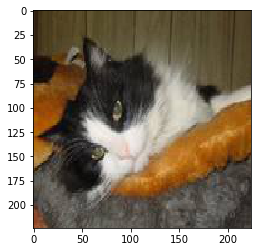

In [31]:
plt.imshow(np.rollaxis(images[0], 0 ,3).astype(np.uint8))

In [124]:
def plots(images,fig_size=(12,6),rows=1,interp=False, titles=None):
    #Create a figure object
    fx = plt.figure(figsize=fig_size)
    for i in range(len(images)):
        sp = fx.add_subplot(rows, len(images)//rows, i+1)
        img = to_plot(images[i])
        if titles is not None:
            sp.set_title(titles[i])
        plt.imshow(img)
        

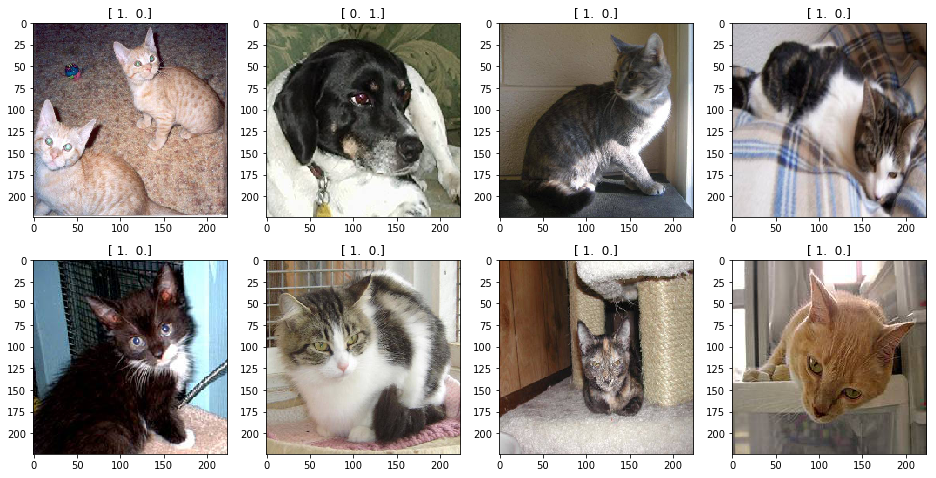

In [126]:
plots(images,fig_size=(16,8), rows = 2, titles=labels)

In [104]:
#Get validation batches
valbatches = get_batches('sample/valid', batch_size=batch_size*2)

Found 120 images belonging to 2 classes.


### Predictions
First predict the best fit class from the 1000 classes in the vgg model  
Then, do the finetune by dropping the top layer a replacing it with two outputs

In [45]:
idxs = np.argmax(preds, axis = 1)

In [35]:
preds = model.predict(images)

In [50]:
def preds_batch(images):
    #Make the predictions
    preds = model.predict(images)
    #Get the indices for the predicted classes
    idxs = np.argmax(preds, axis = 1)
    
    for i in range(len(idxs)):
        idx = idxs[i]
        print('Predicted {0} with a probability of {1}'.format(classes[idx],preds[i,idx]))

In [51]:
preds_batch(images)

Predicted jack-o'-lantern with a probability of 0.284751832485199
Predicted schipperke with a probability of 0.20713239908218384
Predicted beagle with a probability of 0.9577775597572327
Predicted Egyptian_cat with a probability of 0.7256757616996765


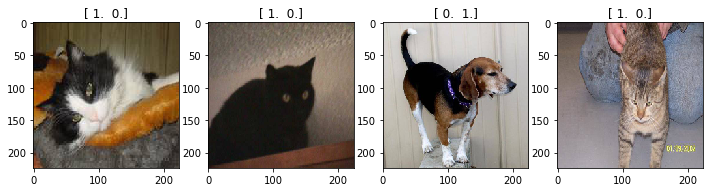

In [52]:
plots(images, titles=labels)

#### Finetuning the model
What to do - drop the layers to finetune - use model.pop()
Add a new dense layer - is specifying output shape enough?

In [ ]:
#Trying a new layer with output shape
# in vgg16.py, jeremy makes all the layers not trainable - no need to update vgg classes

In [113]:
#Assuming the last layer has already been popped
#num is the number of outputs we need
def ft(model, num):
    model.pop()
    for layer in model.layers:
        layer.trainable = False
    model.add(Dense(num))

    

In [127]:
ft(model, batches.num_class)

In [128]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 3, 224, 224)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 3, 226, 226)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 224, 224)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 64, 226, 226)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 224, 224)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 112, 112)      0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 64, 114, 114)      0         
__________

#### Optimizer was not passed properly

In [91]:
 model.compile(optimizer=SGD(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

In [71]:
list(iter(batches.class_indices))

['dog', 'cat']

In [74]:
import vgg16 as vgg

In [86]:
batches.samples

240

In [95]:
#Understand the fit function
def fit(model, batches,val_batches, nb_epoch=1):
    model.fit_generator(batches, steps_per_epoch=batches.samples//batch_size, 
                        epochs = nb_epoch, validation_data=val_batches, validation_steps=20)

In [94]:
model.fit_generator??

In [96]:
fit(model, batches, valbatches, nb_epoch = 2)

Epoch 1/2
60/60 [==============================] - 208s - loss: 5.9972 - acc: 0.6292 - val_loss: 5.6893 - val_acc: 0.6250

#### Performed quite poorly to be honest
Let's try lowering the learning rate while keeping the same optimizer 

In [97]:
 model.compile(optimizer=SGD(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [98]:
fit(model, batches, valbatches, nb_epoch = 2)

Epoch 1/2
60/60 [==============================] - 211s - loss: 3.9222 - acc: 0.6417 - val_loss: 3.5186 - val_acc: 0.5750

#### Again not quite at the levels the vgg model of Jeremy performed
Let's try using the Adam optimizer that he uses

In [100]:
from keras.optimizers import Adam

In [129]:
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [117]:
fit(model, batches, valbatches, nb_epoch = 1)

Epoch 1/1
60/60 [==============================] - 270s - loss: 3.0412 - acc: 0.1750 - val_loss: 1.0788 - val_acc: 0.0187

In [130]:
batch_size = 8
batches = get_batches('sample/train', batch_size=batch_size)
valbatches = get_batches('sample/valid', batch_size = batch_size*2)
fit(model, batches, valbatches, nb_epoch = 3)

Found 240 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Epoch 1/3
30/30 [==============================] - 335s - loss: 1.7039 - acc: 0.6917 - val_loss: 0.4546 - val_acc: 0.9737

In [147]:
model.save_weights(path + 'sample/weights-apr23-tachyon.h5')

In [135]:
def test(model, path_name, batch_size=8):
    test_batches = get_batches(path_name, batch_size=batch_size)
    return test_batches, model.predict_generator(test_batches, steps=test_batches.samples//batch_size, 
                            max_q_size=10, workers=1, pickle_safe=False, verbose=0)
    

In [133]:
path + 'sample/valid'

'data/dogscats/sample/valid'

In [138]:
valid_batches, pred = test(model, 'sample/valid')

Found 120 images belonging to 2 classes.


In [140]:
preds = np.argmax(pred, axis = 1)

In [152]:
expected_labels = valid_batches.classes

In [156]:
idxs = np.where(preds == expected_labels)[0]

In [157]:
correct_images = [valid_batches.filenames[i] for i in idxs]

AttributeError: 'JpegImageFile' object has no attribute 'ndim'

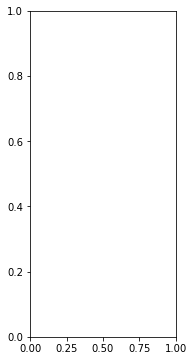

In [161]:
plots([image.load_img(path+'sample/valid/' + correct_images[i]) for i in range(4)])